# MNIST Tutorial for Beginners

Welcome to this comprehensive tutorial on building a simple linear classifier using PyTorch to recognize handwritten digits from the MNIST dataset. This tutorial is designed for individuals who have a basic understanding of Python and machine learning concepts but are new(er) to PyTorch and machine learning.

In this tutorial, you will learn how to:

1. Load and Preprocess Data: Understand how to use PyTorch's DataLoader to load and preprocess the MNIST dataset.
2. Define a Model: Implement a simple linear classifier (logistic regression) using PyTorch's neural network modules.
3. Train the Model: Write a training loop to train your model on the MNIST training dataset.
4. Evaluate the Model: Implement an evaluation function to assess the model's performance on the test dataset.
5. Understand Model Training: Gain insights into key concepts like model training, loss computation, and optimization.
6. Visualize Results: Learn how to visualize and interpret the results of your trained model.

### Loading Libraries and Setting Up

In [50]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

from timeit import default_timer as timer
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' # For faster processing if you have a GPU

# Some Helper functions

In [51]:
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [52]:
def plot_metrics(train_loss, test_loss, train_acc, test_acc):
    epochs = len(train_loss)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [53]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

Loading in data and looking at it thoroughly.

In [54]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

In [55]:
# Basic information about the training and testing dataset
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
img_train, label_train = train_dataset[0]
img_test, label_test = test_dataset[0]
print(f'Shape of each image in the training dataset: {img_train.shape}')
print(f'Shape of each image in the testing dataset: {img_test.shape}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')

Number of training samples: 60000
Number of test samples: 10000
Shape of each image in the training dataset: torch.Size([1, 28, 28])
Shape of each image in the testing dataset: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


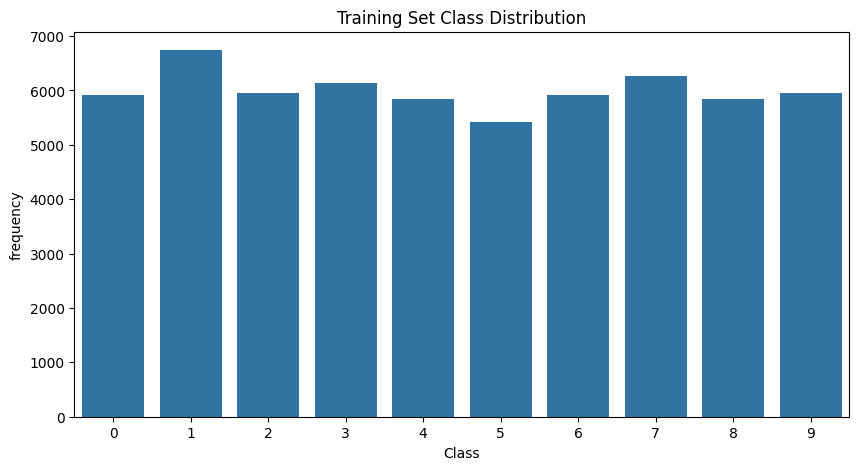

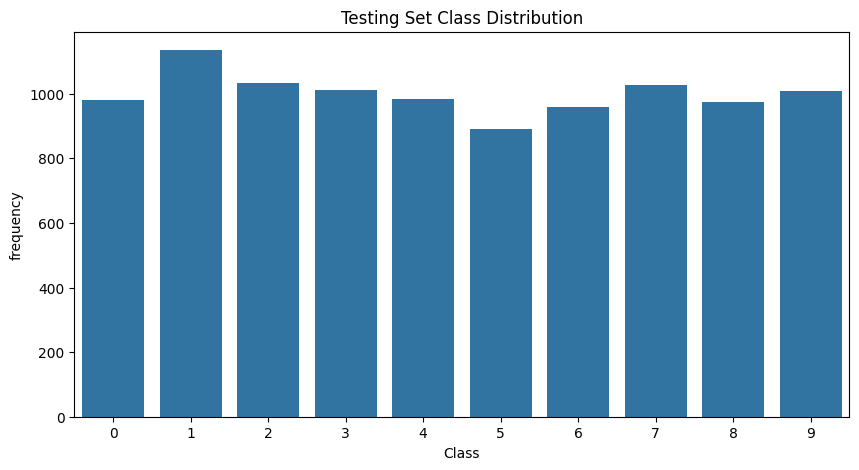

In [56]:
# Let's look at the class distribution. We want to identify whether the classes are balanced.
train_labels_df = pd.DataFrame(train_dataset.targets.numpy(), columns=['label'])
test_labels_df = pd.DataFrame(test_dataset.targets.numpy(), columns=['label'])

def plot_class_distribution(labels_df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=labels_df, x = 'label')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('frequency')
    plt.show()

plot_class_distribution(train_labels_df, 'Training Set Class Distribution')
plot_class_distribution(test_labels_df, 'Testing Set Class Distribution')


We see that the classes are slightly imbalanced. However, we can also observe that the imbalances are roughly similar in both datasets. This indicates (but we never know for certain), that the images are retrieved from the same distribution. 

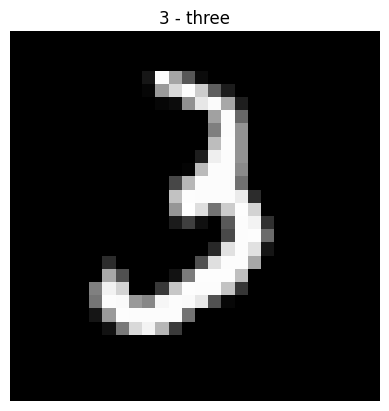

In [57]:
# We might want to set the seed to plot the same images
# torch.manual_seed(9)

class_names = train_dataset.classes

random_idx = torch.randint(low=0, high=len(train_dataset), size=[1]).item()
img, label = train_dataset[random_idx]
plt.imshow(img.squeeze(), cmap='gray') 
plt.title(class_names[label])
plt.axis('off')
plt.show()

From running the above code some times, we can see that most numbers look recognizable, but also that some are more difficult to guess than others. This is something we will have to take into account after our model has made predictions. It's always important to recognize that when our model makes mistakes, we *look* at these mistakes, because maybe we shouldn't call it a mistake:)

When we are working with images, we must not forget that each pixel is a feature. Therefore, as we would normally inspect our features (f.e. in tabular data) and their distribution, we can do the same for the pixels.

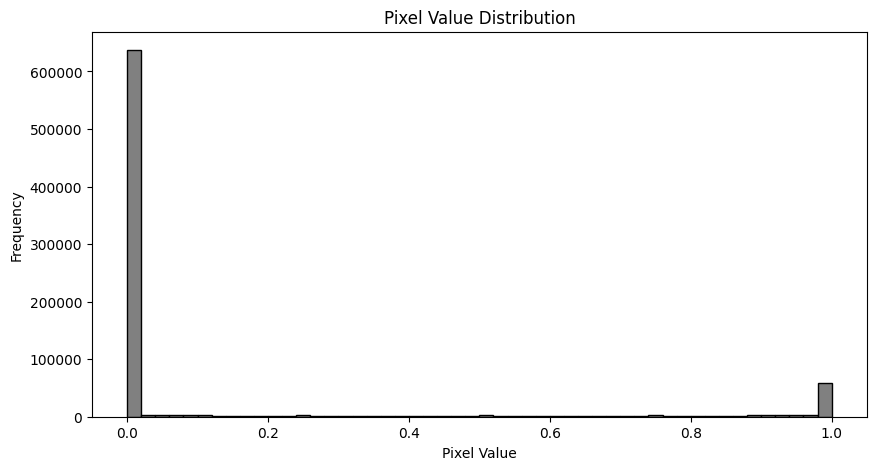

In [58]:
# Visualize the distribution of pixel values
def plot_pixel_distribution(dataset, num_samples=1000):
    pixels = np.concatenate([img.numpy().flatten() for img, _ in torch.utils.data.Subset(dataset, np.random.choice(len(dataset), num_samples, replace=False))])
    plt.figure(figsize=(10, 5))
    plt.hist(pixels, bins=50, color='gray', edgecolor='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Value Distribution')
    plt.show()

plot_pixel_distribution(train_dataset)


Now that we understand roughly what are data looks like, we will use DataLoaders to efficiently load the data into batches, which is important for training neural networks. Moreover, we can decide whether we want to shuffle the data. We want to shuffle the data in the training dataloader to ensure diversity. There is also a lot of built-in support for data iteration, and just overall eases the job for us.

In [59]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Baseline linear model
We build a baseline linear model for comparing with later models.

In [60]:
class BaseLineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=28*28, out_features=10) # Lazy Linear initializes the input_dimension based on the input.

    def forward(self, X):
        return self.linear(X.reshape(-1, 28*28))

We define a training and evaluating loop. This should be generalizable for other models as well.

In [61]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    for X, y in data_loader:
        X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.
        y_pred = model(X) # We make the predictions

        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

In [62]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.

            y_pred = model(X) # We make the predictions

            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_loss += loss.item()
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    
    return test_loss, test_acc

Our entire training pipeline

In [63]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [64]:
EPOCHS = 10

baseline_model = BaseLineModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline_model.parameters(), lr=0.01)

results = train(model=baseline_model, train_dataloader=train_loader, test_dataloader=test_loader, optimizer=optimizer, loss_fn=loss_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.97721 | Train accuracy: 80.40%


 10%|█         | 1/10 [00:08<01:12,  8.10s/it]

Test loss: 0.60068 | Test accuracy: 86.77%
Epoch: 1 | train_loss: 0.9772 | train_acc: 80.4005 | test_loss: 0.6007 | test_acc: 86.7735
Train loss: 0.55165 | Train accuracy: 86.78%


 20%|██        | 2/10 [00:16<01:05,  8.18s/it]

Test loss: 0.47591 | Test accuracy: 88.23%
Epoch: 2 | train_loss: 0.5516 | train_acc: 86.7754 | test_loss: 0.4759 | test_acc: 88.2265
Train loss: 0.47172 | Train accuracy: 87.99%


 30%|███       | 3/10 [00:24<00:56,  8.10s/it]

Test loss: 0.42568 | Test accuracy: 89.17%
Epoch: 3 | train_loss: 0.4717 | train_acc: 87.9881 | test_loss: 0.4257 | test_acc: 89.1720
Train loss: 0.43287 | Train accuracy: 88.67%


 40%|████      | 4/10 [00:32<00:48,  8.05s/it]

Test loss: 0.39745 | Test accuracy: 89.57%
Epoch: 4 | train_loss: 0.4329 | train_acc: 88.6694 | test_loss: 0.3975 | test_acc: 89.5701
Train loss: 0.40886 | Train accuracy: 89.10%


 50%|█████     | 5/10 [00:40<00:40,  8.02s/it]

Test loss: 0.37834 | Test accuracy: 90.07%
Epoch: 5 | train_loss: 0.4089 | train_acc: 89.0958 | test_loss: 0.3783 | test_acc: 90.0677
Train loss: 0.39200 | Train accuracy: 89.47%


 60%|██████    | 6/10 [00:48<00:31,  8.00s/it]

Test loss: 0.36460 | Test accuracy: 90.19%
Epoch: 6 | train_loss: 0.3920 | train_acc: 89.4739 | test_loss: 0.3646 | test_acc: 90.1871
Train loss: 0.37934 | Train accuracy: 89.72%


 70%|███████   | 7/10 [00:56<00:23,  7.98s/it]

Test loss: 0.35410 | Test accuracy: 90.47%
Epoch: 7 | train_loss: 0.3793 | train_acc: 89.7188 | test_loss: 0.3541 | test_acc: 90.4658
Train loss: 0.36932 | Train accuracy: 89.94%


 80%|████████  | 8/10 [01:04<00:15,  7.98s/it]

Test loss: 0.34602 | Test accuracy: 90.64%
Epoch: 8 | train_loss: 0.3693 | train_acc: 89.9420 | test_loss: 0.3460 | test_acc: 90.6449
Train loss: 0.36133 | Train accuracy: 90.13%


 90%|█████████ | 9/10 [01:12<00:07,  7.96s/it]

Test loss: 0.33960 | Test accuracy: 90.80%
Epoch: 9 | train_loss: 0.3613 | train_acc: 90.1336 | test_loss: 0.3396 | test_acc: 90.8041
Train loss: 0.35462 | Train accuracy: 90.26%


100%|██████████| 10/10 [01:20<00:00,  8.01s/it]

Test loss: 0.33342 | Test accuracy: 90.96%
Epoch: 10 | train_loss: 0.3546 | train_acc: 90.2585 | test_loss: 0.3334 | test_acc: 90.9634


In [65]:
results

{'train_loss': [0.9772107126489122,
  0.5516464554869545,
  0.47172473707814205,
  0.43287488444845307,
  0.40885925246899063,
  0.3920019258504737,
  0.37934283367288646,
  0.36932217865102074,
  0.3613323747222103,
  0.35462418829263653],
 'train_acc': [80.40045309168444,
  86.77538646055437,
  87.98807302771856,
  88.6693763326226,
  89.09581556503198,
  89.473947228145,
  89.71881663113007,
  89.94203091684435,
  90.13359541577825,
  90.25852878464819],
 'test_loss': [0.6006828773363381,
  0.47590891200645713,
  0.42567590135297956,
  0.39745324119261116,
  0.37833770409606066,
  0.36459766423246665,
  0.35410384081636265,
  0.34601608678034157,
  0.33959687812028416,
  0.33342201198646976],
 'test_acc': [86.7734872611465,
  88.2265127388535,
  89.171974522293,
  89.57006369426752,
  90.06767515923566,
  90.18710191082802,
  90.4657643312102,
  90.64490445859873,
  90.80414012738854,
  90.96337579617834]}

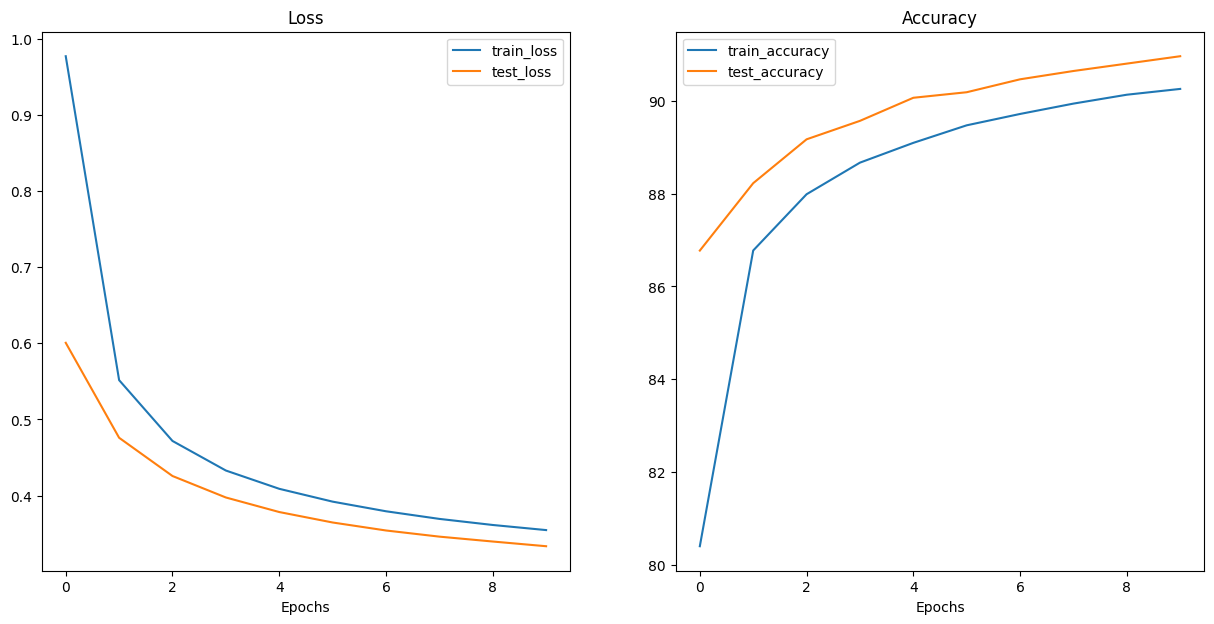

In [67]:
plot_loss_curves(results)